# Imbalanced Data with Credit Card Fraud Detection

## About this Dataset
### This dataset contains two days worth of creditcard transactions made in September of 2013. There are 492 Fraud transactions and 284,807 normal transactions. It contains only numerical input variables due to PCA. It also has three additional comlumns for time, amount and class (whether it is fraud or not). This dataset was taken off of Kaggle and can be found here: https://www.kaggle.com/dalpozz/creditcardfraud.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
data = pd.read_csv('../creditcardfraud/creditcard.csv')

In [3]:
# Viewing the initial data 
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


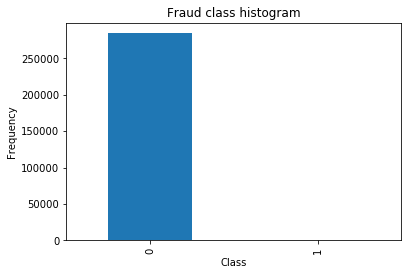

In [4]:
# Viewing the imbalance, although it looks like there are none for class 1, there are just very few
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

# Imbalanced Data and what it means

### Right away we can see that this data is very imbalanced. This means that using accuracy would not be very sufficient. This is because our model would just start guessing that most transactions are not fraud due to the imbalance and give a pretty good accuracy when it may not be justified. Better metrics to use would be AUC, ROC and Recall. I will go more into this later.

### Looking at the initial data we see that amount is on a different numeric scale compared to the PCA values. It is best to scale the data here. I am going to run the code below to scale it down to numbers between -1 and 1. We do this because it allows us to find the local or global maximum master. Having very different values makes the loss function ossilate slower. For more info watch videos by Andrew Ng. We are also dropping time as it does not appear that useful.

In [5]:
#Scaling the amount column to numbers between -1 and 1.

from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

/Users/Scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


## Testing with Undersampled Data 

## Things to note:

## 1. There are differnt ways to combat imbalanced data, such as undersampling, oversampling, smote, collecting more data, etc. 

## 2. For this notebook I decided to stick with undersampling. 

In [6]:
#As the data is very imballanced I am going to first try undersampling to see how well this helps predict the full data
fraud_data_index = np.array(data[data.Class == 1].index)
fraud_number_len = len(data[data.Class == 1])
normal_number_len = len(data[data.Class == 0])
print('Number of Fraud data points ', fraud_number_len)
print('Number of Normal data points ', normal_number_len)

#Defining normal data with index bec np.random needs to work with one dimensional data
normal_data = np.array(data[data.Class == 0].index)
undersampled_normal_index = np.random.choice(normal_data,fraud_number_len, replace = False)
print('Number of undersampled Normal data points', len(undersampled_normal_index))

#Concatenating the two index's together 
undersampled_data_index = np.concatenate([fraud_data_index, undersampled_normal_index])

#Finalizing the undersampled data dataframe
undersampled_data = data.iloc[undersampled_data_index,:]

Number of Fraud data points  492
Number of Normal data points  284315
Number of undersampled Normal data points 492


In [7]:
# Just completing a train test split on the undersampled data and the positive class

from sklearn.cross_validation import train_test_split 

X = undersampled_data.loc[:,undersampled_data.columns != 'Class']
y = undersampled_data.loc[:,undersampled_data.columns == 'Class']

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = .3)

/Users/Scott/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


In [8]:
from sklearn.linear_model import LogisticRegression 
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

## C - Value 
Here we are going to look for the best C parameter. This definition below was borrowed from joparga3 off kaggle. We are looking for the best parameter of C. Having a very large C value is going to try an increase the distance between the clusters while a low C value will try to corectly identify everything leading to high variance. 

In [9]:
def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(len(y_train_data),5,shuffle=False) 

    # Different C parameters
    # Remember that a low C value is trying to maximize the distance between clusters, so it has higher bias 
    # A high C is trying to classify everything correctly which would increase the variance. 
    c_param_range = [0.01,0.1,1,10,100]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())
        
            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [10]:
best_c = printing_Kfold_scores(x_train,y_train)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.926470588235
Iteration  2 : recall score =  0.971428571429
Iteration  3 : recall score =  0.907894736842
Iteration  4 : recall score =  1.0
Iteration  5 : recall score =  0.983606557377

Mean recall score  0.957880090777

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.882352941176
Iteration  2 : recall score =  0.9
Iteration  3 : recall score =  0.828947368421
Iteration  4 : recall score =  0.951612903226
Iteration  5 : recall score =  0.934426229508

Mean recall score  0.899467888466

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.897058823529
Iteration  2 : recall score =  0.9
Iteration  3 : recall score =  0.855263157895
Iteration  4 : recall score =  0.9516129032

## Going to test out different models!

In [11]:
#importing all the required ML packages
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
import seaborn as sns 

In [12]:
#Linear Support Vector Machine 
model=svm.SVC(kernel='linear',C=0.01,gamma=0.1)
model.fit(x_train,y_train.values.ravel())
prediction1=model.predict(x_test)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction1,y_test))

Accuracy for linear SVM is 0.922297297297


In [13]:
#Logistic Regression 
model = LogisticRegression(penalty = 'l1', C = .01)
model.fit(x_train,y_train.values.ravel())
prediction2 =model.predict(x_test)
print('Accuracy for Logistic Regression is',metrics.accuracy_score(prediction2,y_test))

Accuracy for Logistic Regression is 0.918918918919


In [14]:
#Decision Tree 
model = DecisionTreeClassifier()
model.fit(x_train,y_train.values.ravel())
prediction3 =model.predict(x_test)
print('Accuracy for Logistic Regression is',metrics.accuracy_score(prediction3,y_test))

Accuracy for Logistic Regression is 0.89527027027


In [15]:
#Random Forests
model=RandomForestClassifier(n_estimators=100, max_depth = 3)
model.fit(x_train,y_train.values.ravel())
prediction4 = model.predict(x_test)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction4,y_test))

The accuracy of the Random Forests is 0.922297297297


In [16]:
#We are going to bring in Cross Validation to have a more generalized model as it will be testing throughout the training
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=6, random_state=1) # k=6, split the data into 6 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Logistic Regression','Decision Tree','Random Forest']
models=[svm.SVC(kernel='linear'),LogisticRegression(penalty = 'l1', C = .01),DecisionTreeClassifier(),RandomForestClassifier(n_estimators=100, max_depth = 3)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,y.values.ravel(), cv = kfold,scoring = "accuracy")
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.910569,0.046792
Logistic Regression,0.807927,0.084399
Decision Tree,0.872967,0.020351
Random Forest,0.916667,0.069671


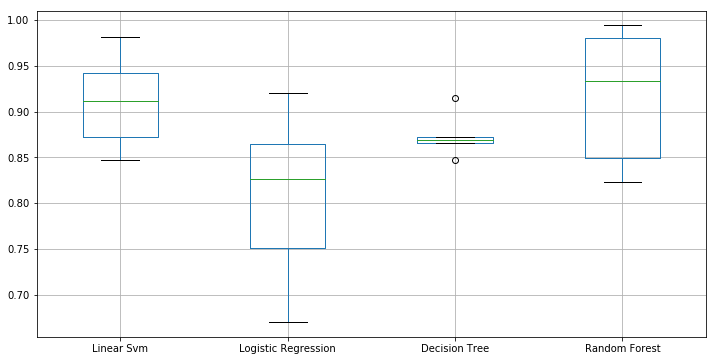

In [17]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

## Able to test for Accuracy for the subsample 

We were able to test for accuracy in this case becuase we standardized and then undersampled the data so there were an equal amount of both. Given there were an equal amount of both, one side would not be pulling the other causing a biased accuracy score. Testing out different models, it appears that the SVM or Random Forest seem to be the best appotions to move forward. Upon continuing with testing our model on the entire dataset were the imbalanced data will be present, we will need to check the Recall score and AUC. I will talk more about this below. 

In [18]:
# Doing a train test split on the entire data set 

X_data = data.loc[:, data.columns != 'Class']
y_data = data.loc[:, data.columns == 'Class']

x_train1, x_test1, y_train1, y_test1 = train_test_split(X_data,y_data,test_size = .3)

In [19]:
## first make a model function for modeling with confusion matrix
def model(model, x_train1, x_test1, y_train1, y_test1):
    clf= model
    clf.fit(x_train1,y_train1.values.ravel())
    pred=clf.predict(x_test1)
    cnf_matrix=confusion_matrix(y_test1,pred)
    print("The recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
    fig= plt.figure(figsize=(6,3))# to plot the graph
    print("TP",cnf_matrix[1,1,]) # no of fraud transaction which are predicted fraud
    print("TN",cnf_matrix[0,0]) # no. of normal transaction which are predited normal
    print("FP",cnf_matrix[0,1]) # no of normal transaction which are predicted fraud
    print("FN",cnf_matrix[1,0]) # no of fraud Transaction which are predicted normal
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(y_test1,pred))

The recall for this model is : 0.858108108108
TP 127
TN 84482
FP 813
FN 21


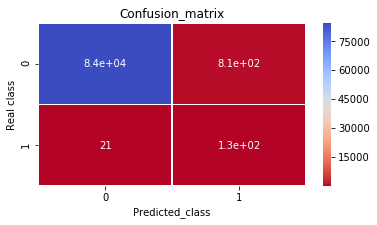


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     85295
          1       0.14      0.86      0.23       148

avg / total       1.00      0.99      0.99     85443



In [20]:
model(RandomForestClassifier(n_estimators=100, max_depth = 3),x_train,x_test1,y_train,y_test1)

The recall for this model is : 0.912162162162
TP 135
TN 77374
FP 7921
FN 13


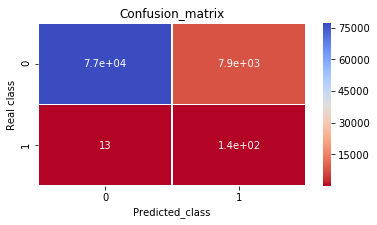


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.91      0.95     85295
          1       0.02      0.91      0.03       148

avg / total       1.00      0.91      0.95     85443



In [21]:
model(LogisticRegression(penalty = 'l1', C = .01),x_train,x_test1,y_train,y_test1)

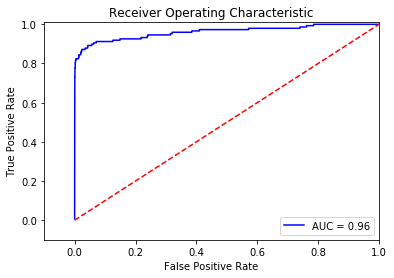

In [22]:
# ROC CURVE
lr = LogisticRegression(C = .01, penalty = 'l1')
y_pred_undersample_score = lr.fit(x_train,y_train.values.ravel()).decision_function(x_test1.values)

fpr, tpr, thresholds = roc_curve(y_test1.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## What the AUC line is telling us 

The AUC ROC curve is telling us how well our predictions are against just randomly guessing. The closer the blue line is to the diagnal the more our prediction is just like randomly guessing. The two classes arene't being seperateed well. However, in this case given the blue line is hugging the upper right hand corner our model is doing a good job at separating the classes fraud vs not fraud. Having more area under the curve is a good thing then and having an AUC of .96 is great while a .5 is just randomly guessing. 

# Conclusion:

Given this is credit card fraudulent data, the data is quite imballanced as we saw above. Due to the imbalance of data we had to take cirtain maeasures to make more valid analysis regarding our prediction. With undersampling I was able to attain a recal score of about 91%. Although this is not a 100% it is still a very good score. The reason it is a good score is because if we keep tweeking things around we wil likely face high variance. That doesn't mean my model can't be improved though. 